# File Storage Indexing - Hariom Vyas (HD59451)

The aim of the project is to go through your Google Drive Storage and create an index of that. Program crawls through your google drive and creates a list of all the filepaths and its metadata.

After getting filepaths, it starts extracting infomration from within the files.

List of file types from which program can extract information is:
* Text
* Docx
* PDF
* Python



## Project Flow
* Connecting to Google Drive
* Setting up PySpark in Colab
* Getting Filepaths of Google Drive Files
* Starting our Spark Journey
* Data Insights and Pre-processing
* Functions to Extract data from different forms of files
* Data Extraction using User Defined Functions
* Query Time
* Continuous Index Updater
* Saving Indexes to CSV

In [1]:
# Connecting my Google Drive to this notebook

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting up PySpark in Colab

In [2]:
## Spark is written in Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, our first task is to download Java.

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
## Now we will install Apache Spark 3.3.1 with Hadoop 3.0.0 and Scala 2.13

!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3-scala2.13.tgz

In [4]:
## Unzipping the file

!tar xf /content/drive/MyDrive/spark-3.3.1-bin-hadoop3-scala2.13.tgz

In [5]:
## We need findspark to locate Spark on the system and import it as a regular library.

!pip install -q findspark

In [6]:
## Setting environment path which will unable us to run Pyspark in the Colab environment.

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3-scala2.13"

In [7]:
## Testing if Spark is installed properly

import findspark
findspark.init()

In [8]:
## Importing SparkSession from pyspark.sql and creating a SparkSession

from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("NimbusStorage")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [9]:
spark

## Getting Filepaths of Google Drive Files

Goal of this Project is to create an indexing of my google drive. So I can perform easy searches on files stored on my Google Drive.

In [10]:
## Importing OS module which will let us perform operations on files and directories

import os

folder = '.'
filepaths = [os.path.join(folder, f) for f in os.listdir(folder)]

In [11]:
## Finding filepaths and directory paths

filepaths = [f.path for f in os.scandir('.') if f.is_file()]
dirpaths  = [f.path for f in os.scandir('.') if f.is_dir()]

In [12]:
## Printing filepaths and directorypaths

for (dirpath, dirnames, filenames) in os.walk('.'):
    for f in filenames:
        print('FILE :', os.path.join(dirpath, f))
    for d in dirnames:
        print('DIRECTORY :', os.path.join(dirpath, d))

Streaming output truncated to the last 5000 lines.
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pip/_vendor/pkg_resources/py31compat.py
DIRECTORY : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pip/_vendor/pkg_resources/__pycache__
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pip/_vendor/pkg_resources/__pycache__/__init__.cpython-39.pyc
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pip/_vendor/pkg_resources/__pycache__/py31compat.cpython-39.pyc
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pip/_vendor/resolvelib/providers.py
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pip/_vendor/resolvelib/structs.py
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pip/_vendor/resolvelib/__init__.py
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pip/_vendor/resolvelib/reporters.py
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packa

In [13]:
## Printing Stats of a random filepath

random_filepath = "./drive/MyDrive/UMBC/Data605/Paper1/Vyas_Hariom_Paper1.docx"
stat_output = os.stat(random_filepath)
print("Stat Output: ", stat_output)
print("Stat Output Type: ", type(stat_output))

Stat Output:  os.stat_result(st_mode=33152, st_ino=76, st_dev=41, st_nlink=1, st_uid=0, st_gid=0, st_size=26073, st_atime=1664712284, st_mtime=1646020812, st_ctime=1664712284)
Stat Output Type:  <class 'os.stat_result'>


Here we are getting lots of information including:
* **st_mode:** It represents file type and file mode bits (permissions).
* **st_ino:** It represents the inode number on Unix and the file index on Windows platform.
* **st_dev:** It represents the identifier of the device on which this file resides.
* **st_nlink:** It represents the number of hard links.
* **st_uid:** It represents the user identifier of the file owner.
* **st_gid:** It represents the group identifier of the file owner.
* **st_size:** It represents the size of the file in bytes.
* **st_atime:** It represents the time of most recent access. It is expressed in seconds.
* **st_mtime:** It represents the time of most recent content modification. It is expressed in seconds.
* **st_ctime:** It represents the time of most recent metadata change on Unix and creation time on Windows. It is expressed in seconds.

In [14]:
## Printing Stats of all the filepaths

for (dirpath, dirnames, filenames) in os.walk('.'):
    for f in filenames:
        print('\nFILE : ', os.path.join(dirpath, f))
        print('Stats: ', os.stat(os.path.join(dirpath, f)))

Streaming output truncated to the last 5000 lines.
FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/streamlit/elements/lib/__pycache__/dicttools.cpython-39.pyc
Stats:  os.stat_result(st_mode=33152, st_ino=10659, st_dev=41, st_nlink=1, st_uid=0, st_gid=0, st_size=2507, st_atime=1670370722, st_mtime=1670060303, st_ctime=1670370722)

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/streamlit/elements/lib/__pycache__/__init__.cpython-39.pyc
Stats:  os.stat_result(st_mode=33152, st_ino=10660, st_dev=41, st_nlink=1, st_uid=0, st_gid=0, st_size=178, st_atime=1670370722, st_mtime=1670060303, st_ctime=1670370722)

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/streamlit/elements/__pycache__/__init__.cpython-39.pyc
Stats:  os.stat_result(st_mode=33152, st_ino=10661, st_dev=41, st_nlink=1, st_uid=0, st_gid=0, st_size=923, st_atime=1670369925, st_mtime=1670060302, st_ctime=1670369925)

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/

In [15]:
## To get certain things we require to create our dataset by accesing each

print(os.path.getsize(random_filepath))
print(os.path.getmtime(random_filepath))
print(os.path.getctime(random_filepath))

26073
1646020812.0
1664712284.0


In [16]:
## For recording the time stamp
from datetime import datetime

## Creating a list containg path of the files and its important metadata that we will use in future

filepaths_list = []

for (dirpath, dirnames, filenames) in os.walk('.'):
    for f in filenames:
        print('\nFILE : ', os.path.join(dirpath, f))
        currentDateAndTime = datetime.now()
        filepaths_list.append((
            os.path.join(dirpath, f), 
            # os.path.get(os.path.join(dirpath, f)), 
            # os.path.getino(os.path.join(dirpath, f)), 
            # os.path.getdev(os.path.join(dirpath, f)),
            # os.path.getnlink(os.path.join(dirpath, f)), 
            # os.path.getuid(os.path.join(dirpath, f)), 
            # os.path.getgid(os.path.join(dirpath, f)),
            os.path.getsize(os.path.join(dirpath, f)), 
            os.path.getatime(os.path.join(dirpath, f)), 
            os.path.getmtime(os.path.join(dirpath, f)),
            os.path.getctime(os.path.join(dirpath, f)),
            currentDateAndTime
        ))
print(filepaths_list)

Streaming output truncated to the last 5000 lines.
FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pytz/zoneinfo/Asia/Omsk

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pytz/zoneinfo/Asia/Irkutsk

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pytz/zoneinfo/Asia/Riyadh

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pytz/zoneinfo/Asia/Nicosia

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pytz/zoneinfo/Asia/Aqtau

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pytz/zoneinfo/Asia/Kamchatka

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pytz/zoneinfo/Asia/Tbilisi

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pytz/zoneinfo/Asia/Baku

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pytz/zoneinfo/Asia/Makassar

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pytz/zoneinfo/Asia/Toky

In [17]:
!pip install folderstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
!folderstats /content/drive/MyDrive -p -i -v -o drive.csv

2022-12-07 04:42:11, folderstats DEBUG FOLDER: /content/drive/MyDrive/Colab Notebooks
2022-12-07 04:42:11, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC
2022-12-07 04:42:11, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data604
2022-12-07 04:42:11, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data604/Week3
2022-12-07 04:42:11, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data604/Week5
2022-12-07 04:42:11, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data604/Week 14
2022-12-07 04:42:11, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data605
2022-12-07 04:42:11, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data605/Paper3
2022-12-07 04:42:11, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data605/Week2
2022-12-07 04:42:11, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data605/Paper2
2022-12-07 04:42:11, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data605/Paper1
2022-12-07 04:42:11, folderstats DEBUG FOLDER

In [19]:
import folderstats

df = folderstats.folderstats('/content/', ignore_hidden=True)
df.head()

id                                               path  \
0   4  /content/spark-3.3.1-bin-hadoop3-scala2.13/yar...   
1   3    /content/spark-3.3.1-bin-hadoop3-scala2.13/yarn   
2   5  /content/spark-3.3.1-bin-hadoop3-scala2.13/LIC...   
3   7  /content/spark-3.3.1-bin-hadoop3-scala2.13/bin...   
4   8  /content/spark-3.3.1-bin-hadoop3-scala2.13/bin...   

                       name extension      size               atime  \
0  spark-3.3.1-yarn-shuffle       jar  11313991 2022-12-07 04:40:23   
1                      yarn      None  11313991 2022-12-07 04:40:43   
2                   LICENSE      None     22940 2022-12-07 04:40:16   
3                   sparkR2       cmd      1097 2022-12-07 04:40:16   
4               spark-class       cmd      1180 2022-12-07 04:40:16   

                mtime               ctime  folder  num_files  depth  parent  \
0 2022-10-15 08:15:23 2022-12-07 04:40:24   False        NaN      2       3   
1 2022-10-15 08:15:22 2022-12-07 04:40:24    True        1.0      2       2   
2 2022-10-15 08:15:25 2022-12-07 04:40:16   False        NaN      1       2   
3 2022-10-15 08:15:25 2022-12-07 04:40:16   False        NaN      2       6   
4 2022-10-15 08:15:25 2022-12-07 04:40:16   False        NaN      2       6   

         uid  
0  110302528  
1  110302528  
2  110302528  
3  110302528  
4  110302528

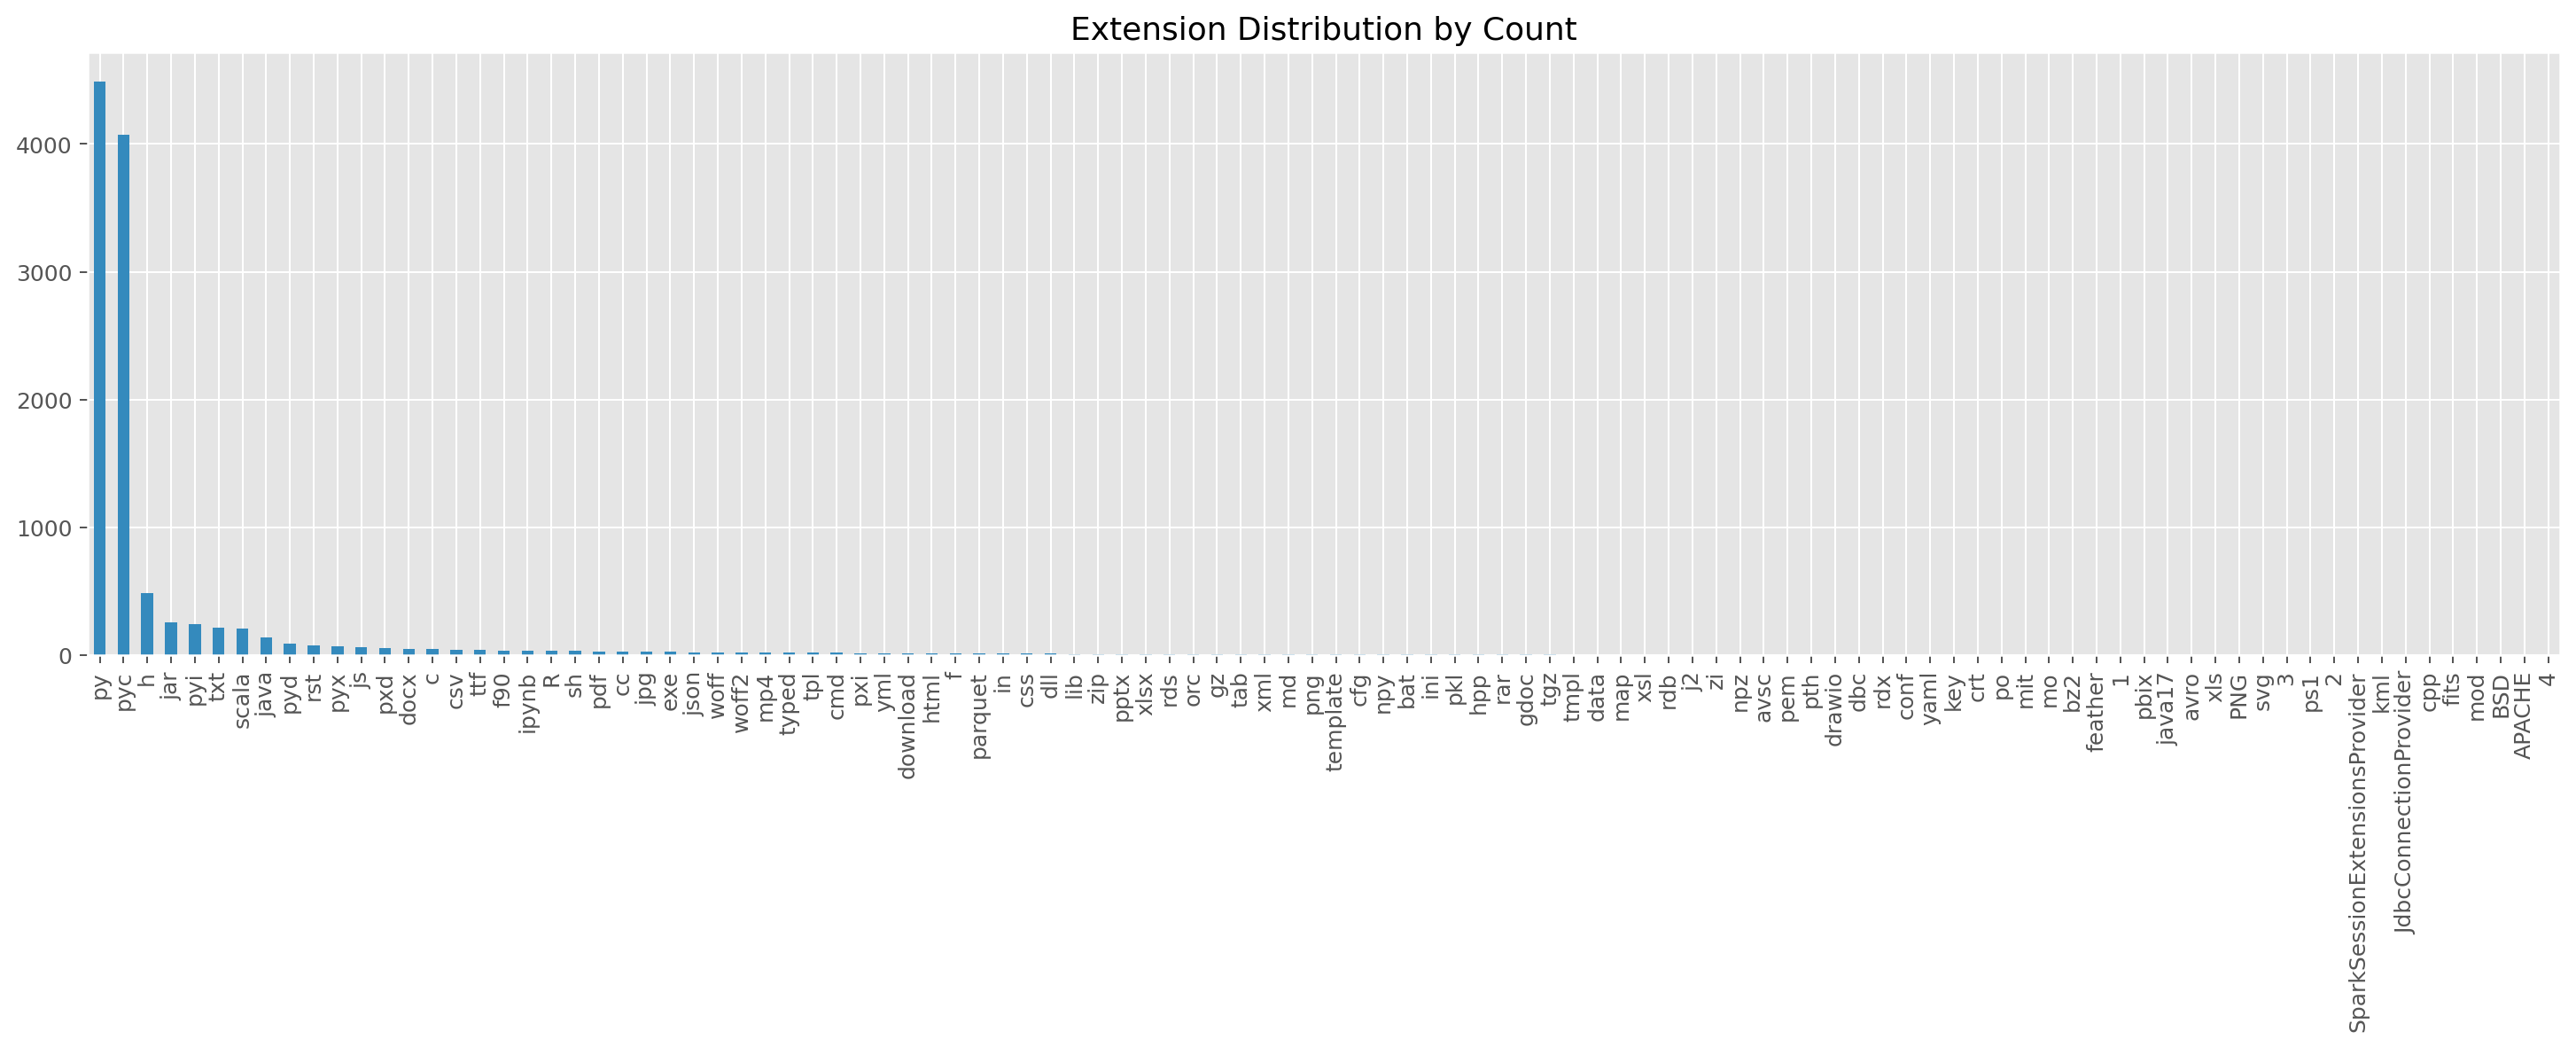

In [20]:
## Exploring File Distribution using Matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(20, 5), dpi=180)

with plt.style.context('ggplot'):
    df['extension'].value_counts().plot(
        kind='bar', color='C1', title='Extension Distribution by Count');

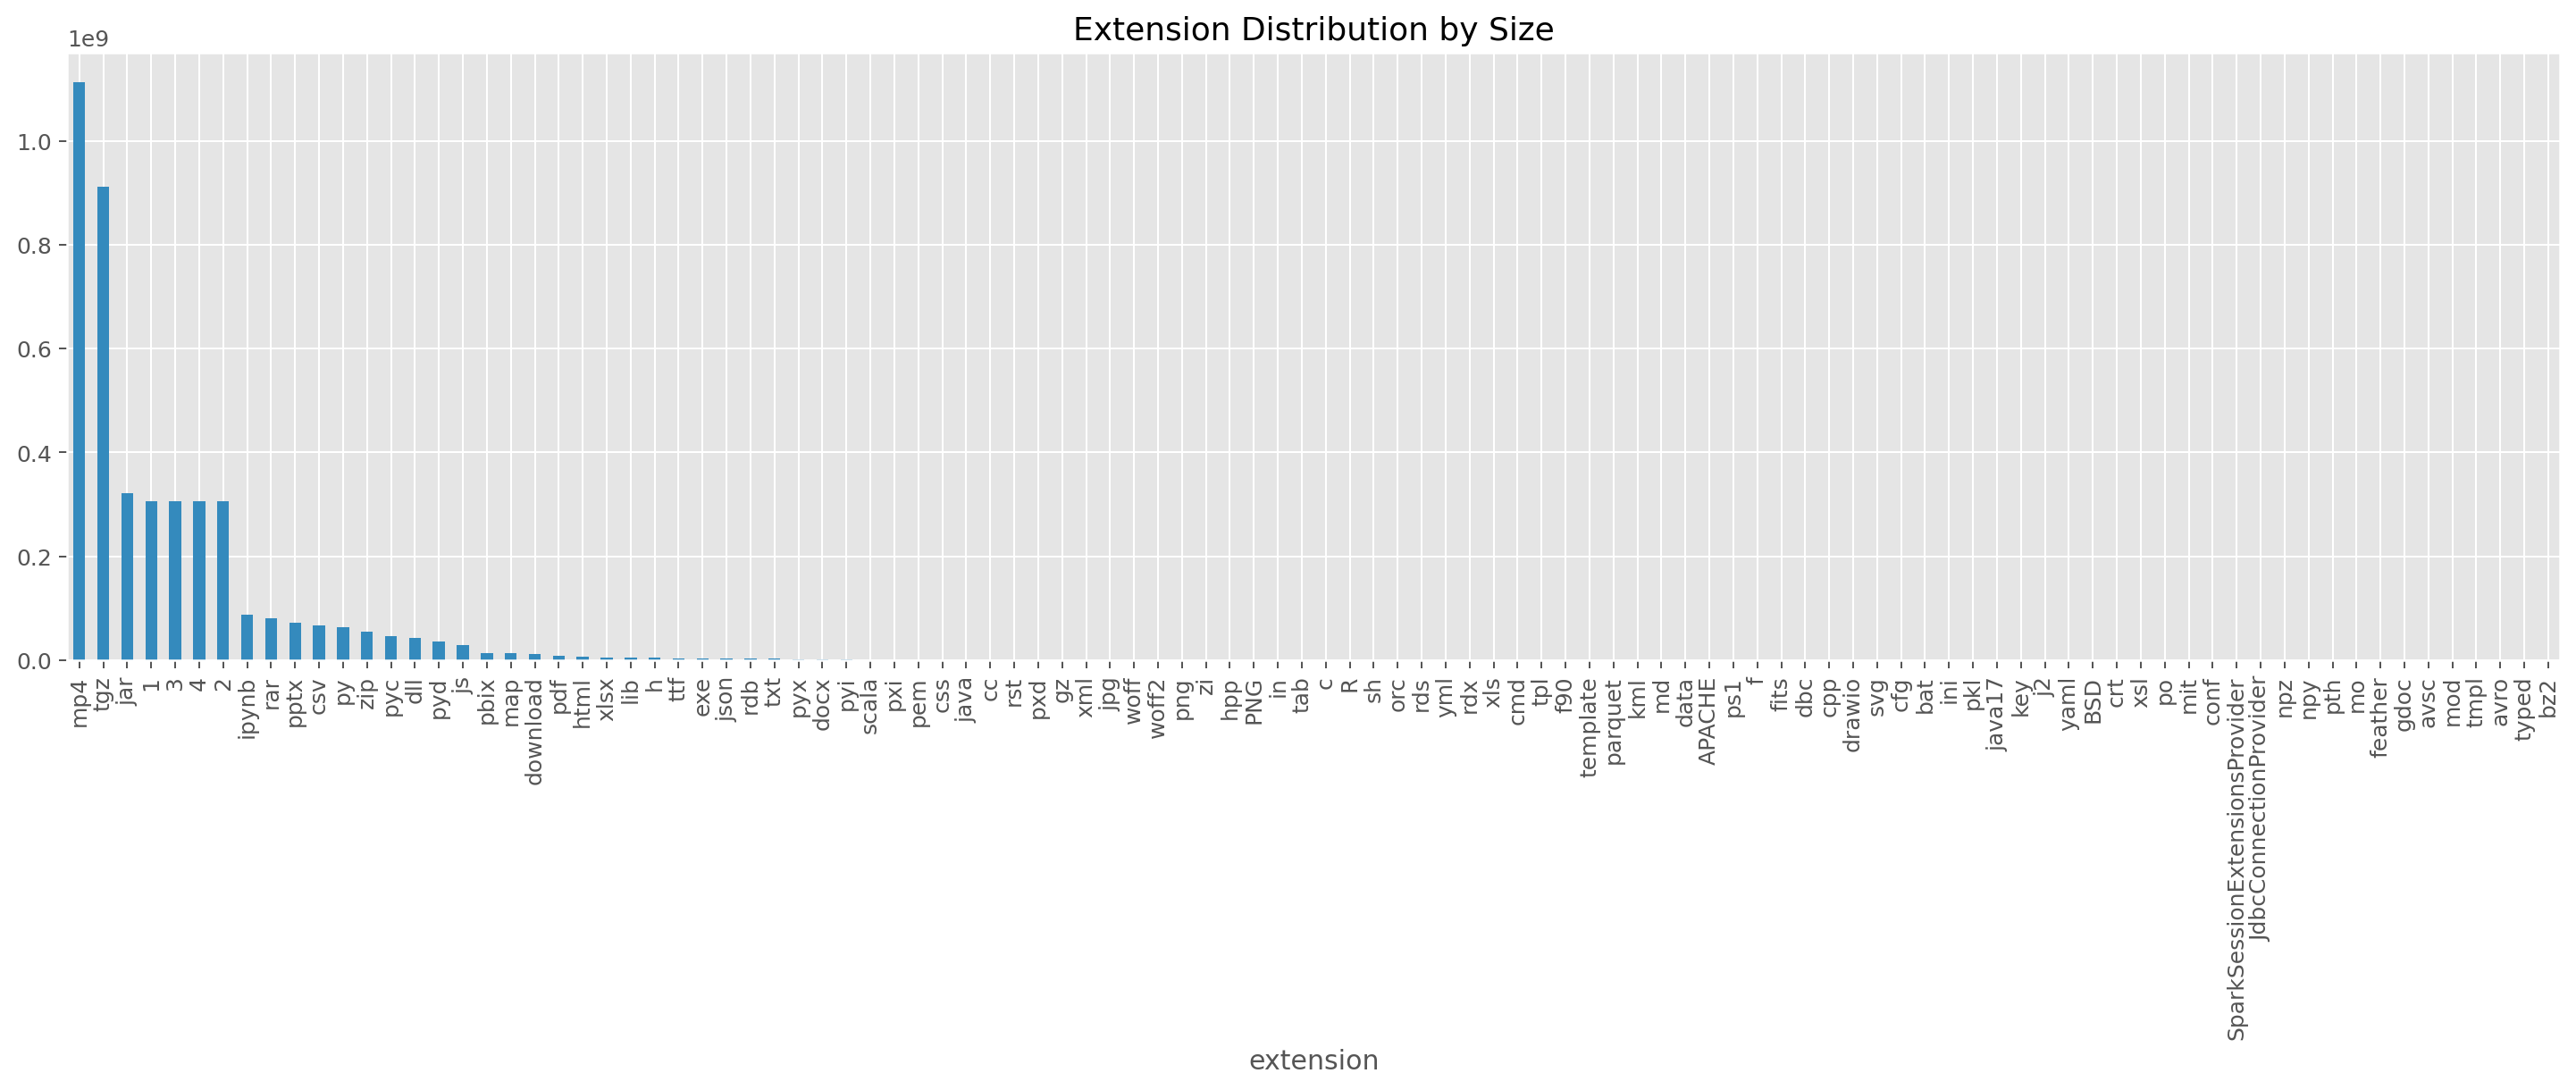

In [21]:
## Extension Distribution by Size

figure(figsize=(20, 5), dpi=180)

with plt.style.context('ggplot'):
    # Group by extension and sum all sizes for each extension 
    extension_sizes = df.groupby('extension')['size'].sum()
    # Sort elements by size
    extension_sizes = extension_sizes.sort_values(ascending=False)
    
    extension_sizes.plot(
        kind='bar', color='C1', title='Extension Distribution by Size');

In [22]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


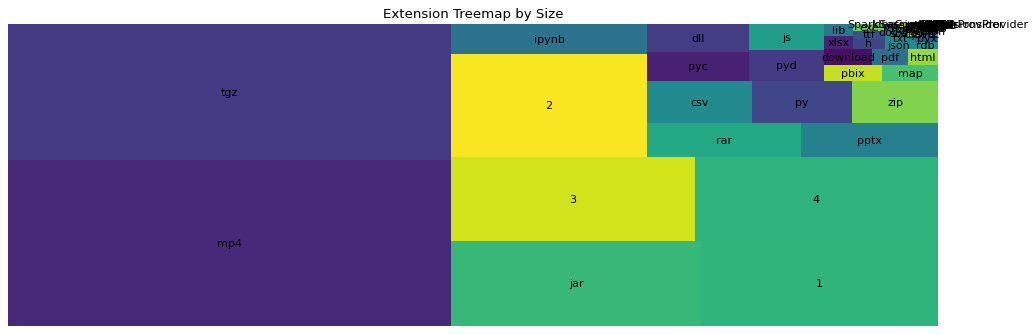

In [23]:
## Treemap with Squarify module to show file counts based on Size

import squarify

# Group by extension and sum all sizes for each extension
extension_sizes = df.groupby('extension')['size'].sum()
# Sort elements by size
extension_counts = extension_sizes.sort_values(ascending=False)
figure(figsize=(15, 5), dpi=80)
squarify.plot(sizes=extension_counts.values, label=extension_counts.index.values)
plt.title('Extension Treemap by Size')
plt.axis('off');

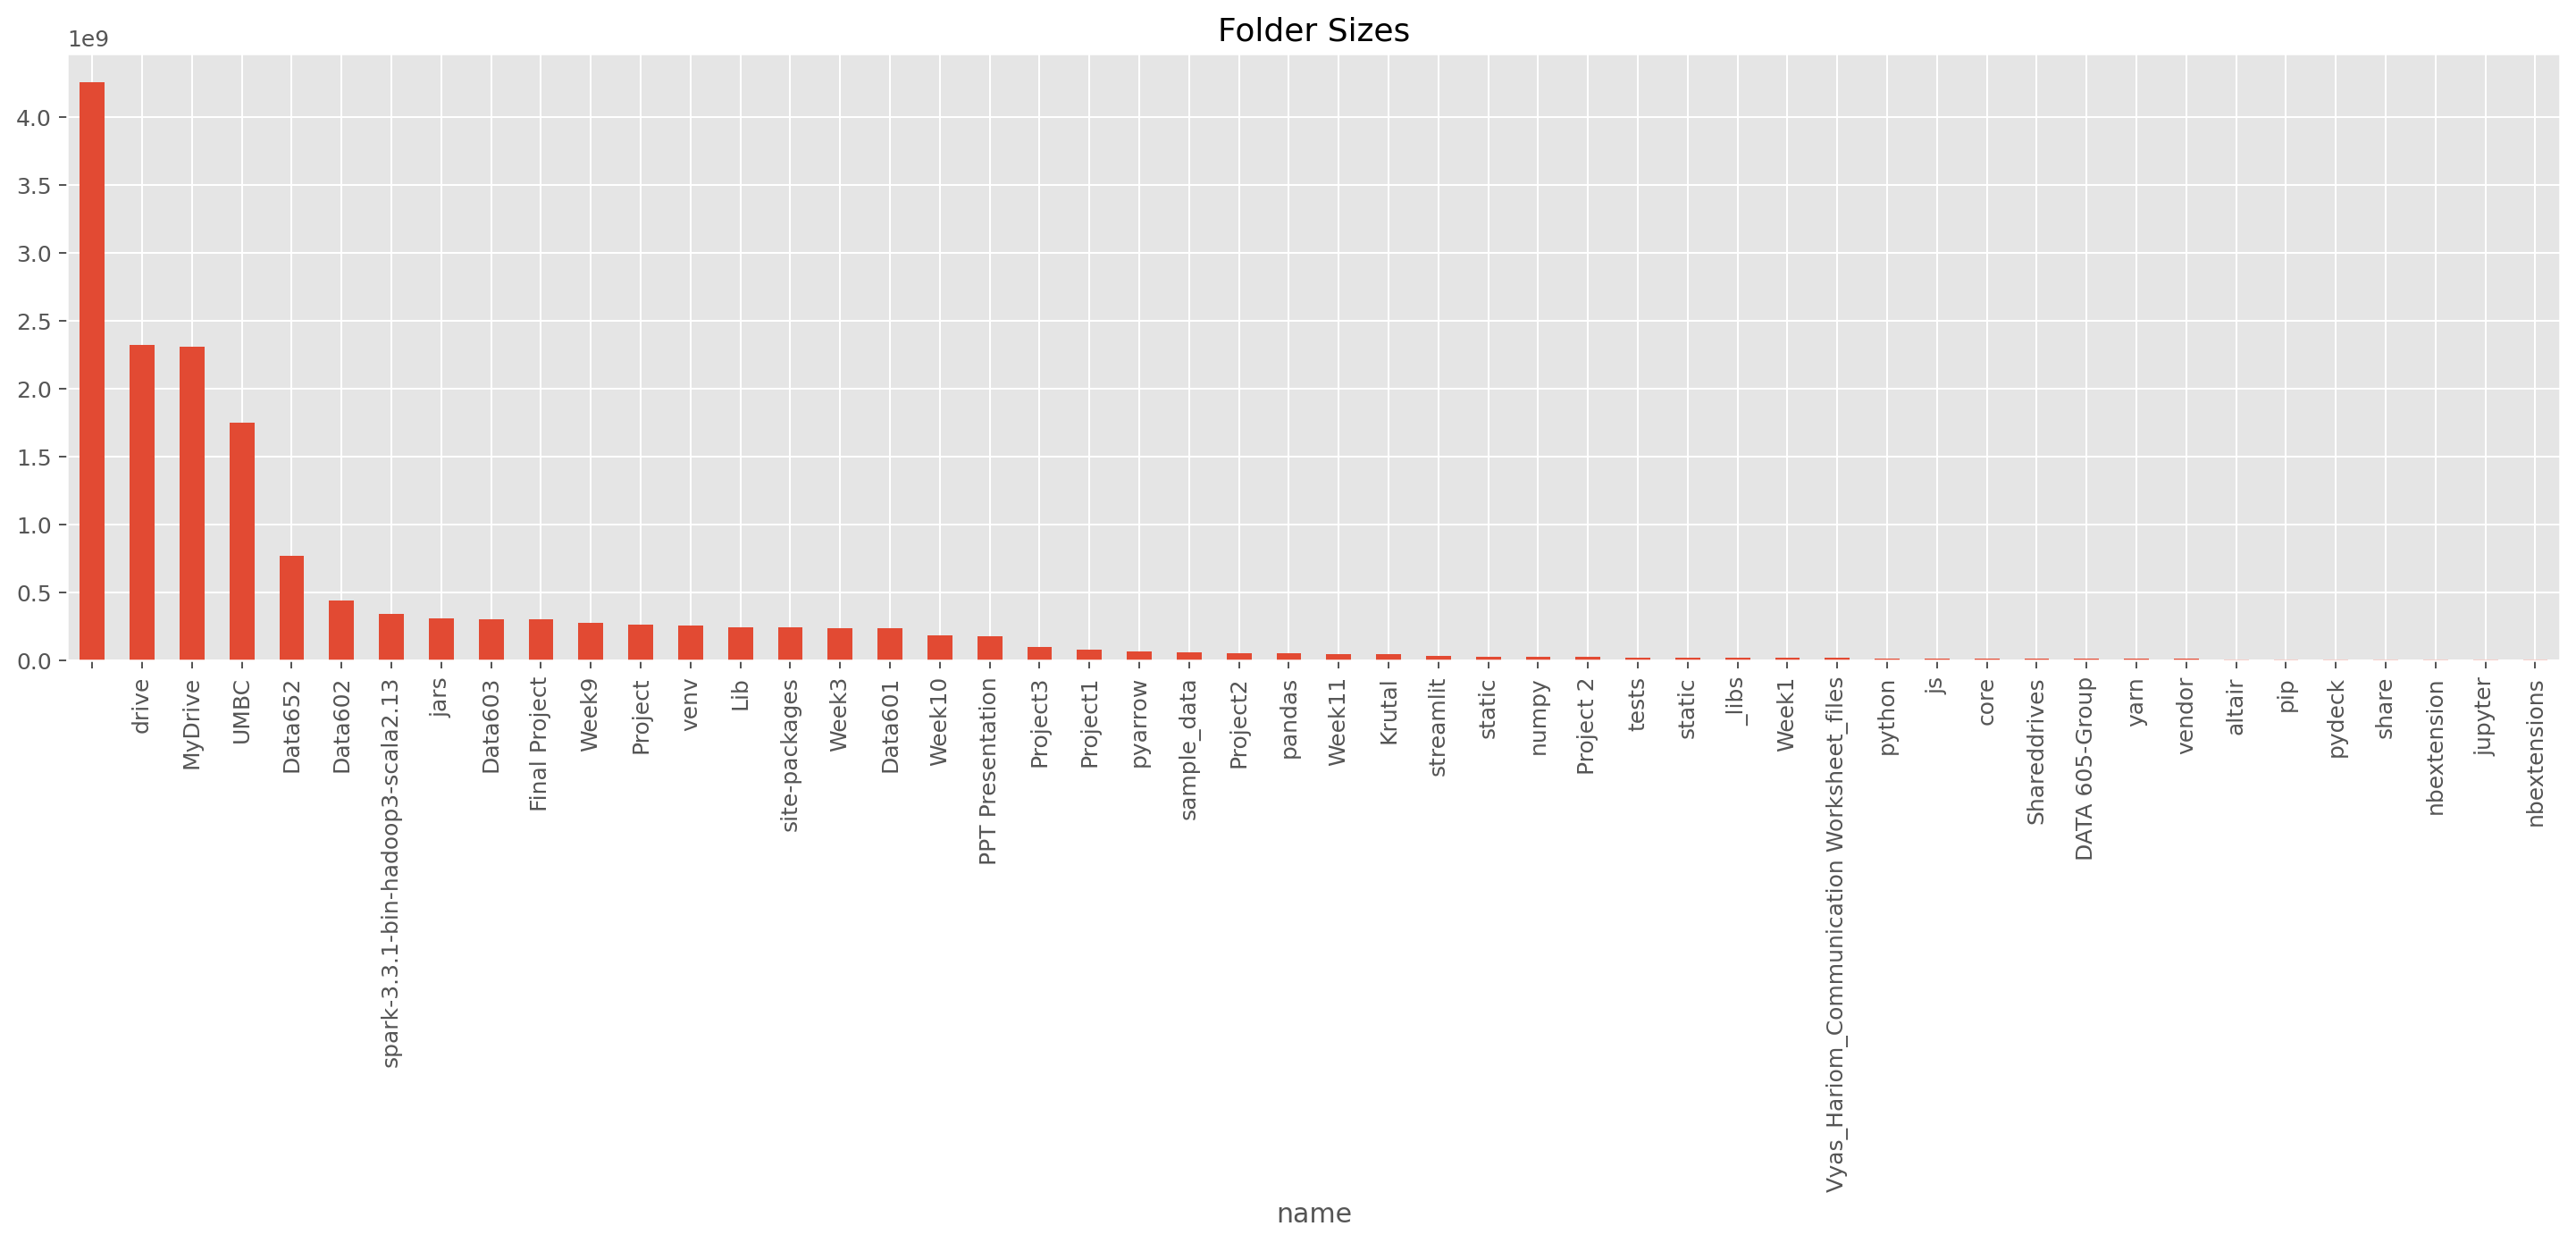

In [24]:
## Visualizing just folders using Matplotlib

figure(figsize=(20, 5), dpi=180)

with plt.style.context('ggplot'):
    # Filter the data set to only folders
    df_folders = df[df['folder']]
    # Set the name to be the index (so we can use it as a label later)
    df_folders.set_index('name', inplace=True)
    # Sort the folders by size
    df_sizes = df_folders.sort_values(by='size', ascending=False)
    
    # Show the size of the largest 50 folders as a bar plot
    df_sizes['size'][:50].plot(kind='bar', color='C0', title='Folder Sizes');

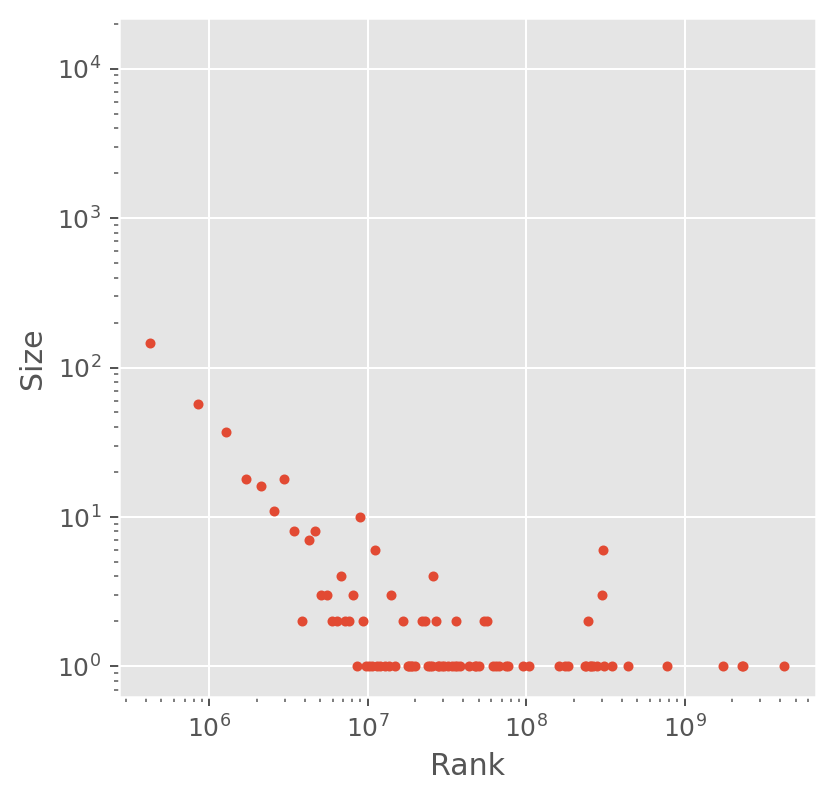

In [25]:
## Log-scale plotting to explore the size and rank

import numpy as np

figure(figsize=(5, 5), dpi=180)

with plt.style.context('ggplot'):
    y, bins = np.histogram(df['size'], bins=10000)
    plt.loglog(bins[:-1], y, '.');
    plt.ylabel('Size')
    plt.xlabel('Rank')

## Starting our Spark Journey

In [26]:
## Importing spark dependencies

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType,StructField, StringType, DoubleType, TimestampType, FloatType
from pyspark.sql.functions import from_unixtime, unix_timestamp, col
import pandas as pd

In [27]:
## Creating Spark Dataframe from our filepaths_list

dfColumns = ["Path", "Size", "MostRecentAccessTime", "MostRecentModificationTime", "MostRecentMetadataChangeTime", "IndexCreationTimestamp"]

filesSchema = StructType([
    StructField('Path', StringType(), True),
    StructField('Size', StringType(), True),
    StructField('MostRecentAccessTime', StringType(), True),
    StructField('MostRecentModificationTime', StringType(), True),
    StructField('MostRecentMetadataChangeTime', StringType(), True),
    StructField('IndexCreationTimestamp', TimestampType(), True),
])

filesDF = spark.createDataFrame(data=filepaths_list, schema = filesSchema)

filesDF.printSchema()
filesDF.show(truncate=False)


root
 |-- Path: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- MostRecentAccessTime: string (nullable = true)
 |-- MostRecentModificationTime: string (nullable = true)
 |-- MostRecentMetadataChangeTime: string (nullable = true)
 |-- IndexCreationTimestamp: timestamp (nullable = true)

+---------------------------------------------+---------+--------------------+--------------------------+----------------------------+--------------------------+
|Path                                         |Size     |MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp    |
+---------------------------------------------+---------+--------------------+--------------------------+----------------------------+--------------------------+
|./spark-3.3.1-bin-hadoop3-scala2.13.tgz.2    |306413381|1.670385436E9       |1.665831233E9             |1.6703854362595801E9        |2022-12-07 04:41:34.398975|
|./drive.csv                                  |

In [28]:
## Creating pandas dataframe for future use

pandasDF = pd.DataFrame(filepaths_list, columns=dfColumns)
pandasDF

Path       Size  \
0       ./spark-3.3.1-bin-hadoop3-scala2.13.tgz.2  306413381   
1                                     ./drive.csv    2624612   
2       ./spark-3.3.1-bin-hadoop3-scala2.13.tgz.3  306413381   
3         ./spark-3.3.1-bin-hadoop3-scala2.13.tgz  306413381   
4       ./spark-3.3.1-bin-hadoop3-scala2.13.tgz.1  306413381   
...                                           ...        ...   
12824                     ./sample_data/README.md        930   
12825   ./sample_data/california_housing_test.csv     301141   
12826  ./sample_data/california_housing_train.csv    1706430   
12827                ./sample_data/mnist_test.csv   18289443   
12828         ./sample_data/mnist_train_small.csv   36523880   

       MostRecentAccessTime  MostRecentModificationTime  \
0              1.670385e+09                1.665831e+09   
1              1.670384e+09                1.670387e+09   
2              1.670387e+09                1.665831e+09   
3              1.670384e+09                1.665831e+09   
4              1.670385e+09                1.665831e+09   
...                     ...                         ...   
12824          9.467136e+08                9.467136e+08   
12825          1.670251e+09                1.670251e+09   
12826          1.670251e+09                1.670251e+09   
12827          1.670251e+09                1.670251e+09   
12828          1.670251e+09                1.670251e+09   

       MostRecentMetadataChangeTime     IndexCreationTimestamp  
0                      1.670385e+09 2022-12-07 04:41:34.398975  
1                      1.670387e+09 2022-12-07 04:41:34.399083  
2                      1.670387e+09 2022-12-07 04:41:34.399147  
3                      1.670384e+09 2022-12-07 04:41:34.399211  
4                      1.670385e+09 2022-12-07 04:41:34.399275  
...                             ...                        ...  
12824                  1.670254e+09 2022-12-07 04:42:07.025674  
12825                  1.670254e+09 2022-12-07 04:42:07.026717  
12826                  1.670254e+09 2022-12-07 04:42:07.027728  
12827                  1.670254e+09 2022-12-07 04:42:07.028724  
12828                  1.670254e+09 2022-12-07 04:42:07.029715  

[12829 rows x 6 columns]

## Data Insights and Pre-processing

In [29]:
## Changing column types to float for "Size" column

filesDF = filesDF.withColumn("Size", filesDF["Size"].cast(FloatType()))

#.withColumn("MostRecentAccessTime", filesDF["MostRecentAccessTime"].cast(TimestampType())).withColumn("MostRecentModificationTime", filesDF["MostRecentModificationTime"].cast(TimestampType())).withColumn("MostRecentMetadataChangeTime", filesDF["MostRecentMetadataChangeTime"].cast(TimestampType()))
filesDF.printSchema()

root
 |-- Path: string (nullable = true)
 |-- Size: float (nullable = true)
 |-- MostRecentAccessTime: string (nullable = true)
 |-- MostRecentModificationTime: string (nullable = true)
 |-- MostRecentMetadataChangeTime: string (nullable = true)
 |-- IndexCreationTimestamp: timestamp (nullable = true)



In [30]:
# # Changing colum type to time for other columns

# filesDF = filesDF.select(
#     from_unixtime(col("MostRecentAccessTime")).as("MostRecentAccessTime"),
#     from_unixtime(col("MostRecentModificationTime"), "MM-dd-yyyy HH:mm:ss").alias("MostRecentModificationTime"),
#     from_unixtime(col("MostRecentMetadataChangeTime"), "MM-dd-yyyy HH:mm:ss").alias("MostRecentMetadataChangeTime"),
# )

In [31]:
filesDF.printSchema()
filesDF.show(truncate=False)

root
 |-- Path: string (nullable = true)
 |-- Size: float (nullable = true)
 |-- MostRecentAccessTime: string (nullable = true)
 |-- MostRecentModificationTime: string (nullable = true)
 |-- MostRecentMetadataChangeTime: string (nullable = true)
 |-- IndexCreationTimestamp: timestamp (nullable = true)

+---------------------------------------------+------------+--------------------+--------------------------+----------------------------+--------------------------+
|Path                                         |Size        |MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp    |
+---------------------------------------------+------------+--------------------+--------------------------+----------------------------+--------------------------+
|./spark-3.3.1-bin-hadoop3-scala2.13.tgz.2    |3.06413376E8|1.670385436E9       |1.665831233E9             |1.6703854362595801E9        |2022-12-07 04:41:34.398975|
|./drive.csv                        

In [32]:
filesDF.show(10)

+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|        Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+
|./spark-3.3.1-bin...|3.06413376E8|       1.670385436E9|             1.665831233E9|        1.6703854362595801E9|  2022-12-07 04:41:...|
|         ./drive.csv|   2624612.0|1.6703838708827753E9|      1.6703871957292175E9|        1.6703871957292175E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|3.06413376E8|       1.670387081E9|             1.665831233E9|        1.6703870816534889E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|3.06413376E8|       1.670383974E9|             1.665831233E9|        1.6703839744907026E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|3.06413376E8|       1.6703

In [33]:
filesDF.count()

12829

In [34]:
filesDF.summary().show()

+-------+--------------------+------------------+--------------------+--------------------------+----------------------------+
|summary|                Path|              Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|
+-------+--------------------+------------------+--------------------+--------------------------+----------------------------+
|  count|               12829|             12829|               12829|                     12829|                       12829|
|   mean|                null|341637.87497076934|1.6701187373245628E9|      1.6689485558913226E9|        1.6703182826976461E9|
| stddev|                null| 7885053.249580654|1.7945292661592662E7|      1.2752923866692556E7|            604240.376730149|
|    min|./.config/.last_o...|               0.0|                 0.0|             1.385644837E9|               1.650388363E9|
|    25%|                null|            1105.0|       1.670369085E9|             1.670060272E9|              

In [35]:
filesDF.describe().show()

+-------+--------------------+------------------+--------------------+--------------------------+----------------------------+
|summary|                Path|              Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|
+-------+--------------------+------------------+--------------------+--------------------------+----------------------------+
|  count|               12829|             12829|               12829|                     12829|                       12829|
|   mean|                null|341637.87497076934|1.6701187373245628E9|      1.6689485558913226E9|        1.6703182826976461E9|
| stddev|                null| 7885053.249580654|1.7945292661592662E7|      1.2752923866692556E7|            604240.376730149|
|    min|./.config/.last_o...|               0.0|                 0.0|             1.385644837E9|               1.650388363E9|
|    max|./spark-3.3.1-bin...|      3.06413376E8|          9.467136E8|                9.467136E8|              

In [36]:
filesDF.orderBy("Size").show()

+--------------------+----+--------------------+--------------------------+----------------------------+----------------------+
|                Path|Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+----+--------------------+--------------------------+----------------------------+----------------------+
|./drive/MyDrive/U...| 0.0|       1.670368347E9|             1.670060294E9|               1.670368347E9|  2022-12-07 04:41:...|
|./drive/MyDrive/U...| 0.0|       1.670369369E9|             1.670060273E9|               1.670369369E9|  2022-12-07 04:41:...|
|./drive/MyDrive/U...| 0.0|       1.670368701E9|             1.670060294E9|               1.670368701E9|  2022-12-07 04:41:...|
|./drive/MyDrive/U...| 0.0|       1.670368343E9|             1.670060294E9|               1.670368343E9|  2022-12-07 04:41:...|
|./drive/MyDrive/U...| 0.0|       1.670368363E9|               1.6700603E9|               1.670368363E9|

In [37]:
# Finding null values in data

filesDF.filter(filesDF.Path.isNull()).show()
filesDF.filter(filesDF.Size.isNull()).show()
filesDF.filter(filesDF.MostRecentAccessTime.isNull()).show()
filesDF.filter(filesDF.MostRecentModificationTime.isNull()).show()
filesDF.filter(filesDF.MostRecentMetadataChangeTime.isNull()).show()

+----+----+--------------------+--------------------------+----------------------------+----------------------+
|Path|Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+----+----+--------------------+--------------------------+----------------------------+----------------------+
+----+----+--------------------+--------------------------+----------------------------+----------------------+

+----+----+--------------------+--------------------------+----------------------------+----------------------+
|Path|Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+----+----+--------------------+--------------------------+----------------------------+----------------------+
+----+----+--------------------+--------------------------+----------------------------+----------------------+

+----+----+--------------------+--------------------------+----------------------------+--------------

## Creating Functions to Extract data from different forms of files

In [38]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
!pip install docx2txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
## Importing required libraries

import pandas as pd
from pyspark.sql.functions import col, pandas_udf, when, udf
from pyspark.sql.types import LongType
from pyspark.sql import Window

# For PDF Extraction
import PyPDF2

# For Docx
import docx2txt

In [41]:
# Function to extract data from text file

def extract_from_txt(files_list: pd.Series) -> pd.Series:

  f = open(files_list, "r")
  readtext = f.read()

  return readtext

# creating the pandas udf for extraction function
txt_udf = pandas_udf(extract_from_txt, returnType=StringType())

spark.udf.register("ExtractFromTxt", extract_from_txt)

<function __main__.extract_from_txt(files_list: pandas.core.series.Series) -> pandas.core.series.Series>

In [42]:
# Function to extract data from Python file

def extract_from_py(files_list: pd.Series) -> pd.Series:

  f = open(files_list, "r")
  readtext = f.read()

  return readtext

# creating the pandas udf for extraction function
py_udf = pandas_udf(extract_from_py, returnType=StringType())

spark.udf.register("ExtractFromPy", extract_from_py)

<function __main__.extract_from_py(files_list: pandas.core.series.Series) -> pandas.core.series.Series>

In [43]:
# Function to extract data from Docx file

def extract_from_docx(files_list: pd.Series) -> pd.Series:

  my_text = docx2txt.process(zip(files_list))
  return my_text

# creating the pandas udf for extraction function
docx_udf = pandas_udf(extract_from_docx, returnType=StringType())

spark.udf.register("extract_from_docx", extract_from_docx)

<function __main__.extract_from_docx(files_list: pandas.core.series.Series) -> pandas.core.series.Series>

In [44]:
# Function to extract data from pdf file

def extract_from_pdf(files_list: pd.Series) -> pd.Series:
  extracted_text = ""
  
  # creating a pdf file object
  pdfFileObj = open(files_list, 'rb')
    
  # creating a pdf reader object
  pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

  for i in range(pdfReader.numPages):  
    # creating a page object
    pageObj = pdfReader.getPage(i)  
    extracted_text = extracted_text + pageObj.extractText()
    
  # closing the pdf file object
  pdfFileObj.close()

  return extracted_text

# creating the pandas udf for extraction function
pdf_udf = pandas_udf(extract_from_pdf, returnType=StringType())

spark.udf.register("extract_from_pdf", extract_from_pdf)

<function __main__.extract_from_pdf(files_list: pandas.core.series.Series) -> pandas.core.series.Series>

In [45]:
# # Function to extract data from csv file

# def extract_from_csv(files_list: pd.Series) -> pd.Series:

#   df = pd.read_csv(files_list)
#   return df

# # creating the pandas udf for extraction function
# csv_udf = pandas_udf(extract_from_pdf, returnType=StringType())

In [46]:
# # Function to extract data from excel file

# def extract_from_excel(files_list: pd.Series) -> pd.Series:



In [47]:
# # Function to extract data from image file

# def extract_from_img(files_list: pd.Series) -> pd.Series:


In [48]:
filesDF.show(10)

+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|        Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+
|./spark-3.3.1-bin...|3.06413376E8|       1.670385436E9|             1.665831233E9|        1.6703854362595801E9|  2022-12-07 04:41:...|
|         ./drive.csv|   2624612.0|1.6703838708827753E9|      1.6703871957292175E9|        1.6703871957292175E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|3.06413376E8|       1.670387081E9|             1.665831233E9|        1.6703870816534889E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|3.06413376E8|       1.670383974E9|             1.665831233E9|        1.6703839744907026E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|3.06413376E8|       1.6703

## Extracting data using User Defined Functions

In [49]:
## Creating Doxc file dataframe to extract data

docx_filesDF = filesDF.filter(filesDF.Path.endswith(".docx"))
docx_filesDF.show(10)

+--------------------+-------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|   Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+-------+--------------------+--------------------------+----------------------------+----------------------+
|./drive/MyDrive/U...|97307.0|        1.66471228E9|             1.647546659E9|                1.66471228E9|  2022-12-07 04:41:...|
|./drive/MyDrive/U...|  162.0|       1.664712282E9|             1.645810757E9|               1.664712282E9|  2022-12-07 04:41:...|
|./drive/MyDrive/U...|  162.0|       1.664712283E9|             1.651773503E9|               1.664712283E9|  2022-12-07 04:41:...|
|./drive/MyDrive/U...|28102.0|       1.664712281E9|              1.65232098E9|               1.664712281E9|  2022-12-07 04:41:...|
|./drive/MyDrive/U...|  162.0|       1.664712283E9|             1.645810757E9|     

In [50]:
docx_filesDF.count()

49

In [51]:
# ## Extracting data from Docx Files

# extract_from_docx = udf(extract_from_docx, StringType())
# docx_filesDF.select("Path", "Size", "MostRecentAccessTime", "MostRecentModificationTime", "MostRecentMetadataChangeTime", "IndexCreationTimestamp", extract_from_docx("Path").alias("Text")).show()

In [52]:
## Creating Pdf file dataframe to extract data

pdf_filesDF = filesDF.filter(filesDF.Path.endswith(".pdf"))
pdf_filesDF.show(10)

+--------------------+---------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|     Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+---------+--------------------+--------------------------+----------------------------+----------------------+
|./drive/MyDrive/V...| 171579.0|                 0.0|             1.654529927E9|               1.654529927E9|  2022-12-07 04:41:...|
|./drive/MyDrive/H...| 130340.0|       1.666381133E9|             1.662589643E9|               1.666381133E9|  2022-12-07 04:41:...|
|./drive/MyDrive/U...|  62000.0|        1.66471228E9|             1.647546675E9|                1.66471228E9|  2022-12-07 04:41:...|
|./drive/MyDrive/U...|  69962.0|       1.664712281E9|             1.652320961E9|               1.664712281E9|  2022-12-07 04:41:...|
|./drive/MyDrive/U...| 120499.0|       1.664712283E9|             1.6

In [53]:
pdf_filesDF.count()

30

In [54]:
## Extracting data from PDF Files

extract_from_pdf = udf(extract_from_pdf, StringType())
extracted_pdf_dataDF = pdf_filesDF.select("Path", extract_from_pdf("Path").alias("Text"))

In [55]:
extracted_pdf_dataDF.show()

+--------------------+--------------------+
|                Path|                Text|
+--------------------+--------------------+
|./drive/MyDrive/V...|Hariom Vyas  \n11...|
|./drive/MyDrive/H...|Hariom Vyas  \nha...|
|./drive/MyDrive/U...|Homework 1 - Data...|
|./drive/MyDrive/U...|1 \n \n \n \n \n ...|
|./drive/MyDrive/U...|1 \n \n \n \n \n ...|
|./drive/MyDrive/U...|Your First Manage...|
|./drive/MyDrive/U...|Creatingandsustai...|
|./drive/MyDrive/U...|case W23C29\nSept...|
|./drive/MyDrive/U...|www.hbrreprints.o...|
|./drive/MyDrive/U...|HBR.ORGJANUARY 20...|
|./drive/MyDrive/U...| \n9-617- 046 \nR...|
|./drive/MyDrive/U...|Writing an Execut...|
|./drive/MyDrive/U...| \n \n   W16316  ...|
|./drive/MyDrive/U...|case W82C83 \nNov...|
|./drive/MyDrive/U...| 9-304-070\nREV: ...|
|./drive/MyDrive/U...|1 \n \n \n \n \n ...|
|./drive/MyDrive/U...|Employee Informat...|
|./drive/MyDrive/U...|1 \n \n \n \n \n ...|
|./drive/MyDrive/U...| \n \n \n \nLeade...|
|./drive/MyDrive/U...|AHP Assign

In [56]:
## Creating Python file dataframe to extract data

py_filesDF = filesDF.filter(filesDF.Path.endswith(".py"))
py_filesDF.show(10)

+--------------------+--------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|    Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+--------+--------------------+--------------------------+----------------------------+----------------------+
|./spark-3.3.1-bin...| 14341.0|1.6703880238945756E9|             1.665821727E9|        1.6703880238945756E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...| 13289.0|1.6703880238945756E9|             1.665821727E9|        1.6703880238945756E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|  4242.0| 1.670388023859573E9|             1.665821727E9|         1.670388023859573E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...| 10421.0| 1.670388023886575E9|             1.665821727E9|         1.670388023887575E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|  3999.0| 1.670388023772566E9|             1.665821726

In [57]:
py_filesDF.count()

4491

In [58]:
## Extracting data from Python Files

extract_from_py = udf(extract_from_py, StringType())
extracted_py_dataDF = py_filesDF.select("Path", extract_from_py("Path").alias("Text"))

In [59]:
extracted_py_dataDF.show()

+--------------------+--------------------+
|                Path|                Text|
+--------------------+--------------------+
|./spark-3.3.1-bin...|#!/usr/bin/env py...|
|./spark-3.3.1-bin...|#!/usr/bin/env py...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|"""\nCopyright (c...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#!/usr/bin/env py...|
|./spark-3.3.1-bin...|# -*- coding: utf...|
|./spark-3.3.1-bin...|#\n# Licen

In [60]:
## Creating Text file dataframe to extract data

txt_filesDF = filesDF.filter(filesDF.Path.endswith(".txt"))
txt_filesDF.show(10)

+--------------------+--------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|    Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+--------+--------------------+--------------------------+----------------------------+----------------------+
|./spark-3.3.1-bin...|    13.0|1.6703880238955755E9|             1.665821727E9|        1.6703880238955755E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|    17.0|1.6703880238955755E9|             1.665821727E9|        1.6703880238955755E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|    10.0|1.6703880239005759E9|             1.665821727E9|        1.6703880239005759E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|    10.0| 1.670388023899576E9|             1.665821727E9|        1.6703880239005759E9|  2022-12-07 04:41:...|
|./spark-3.3.1-bin...|  1445.0|1.6703880237465641E9|             1.665821726

In [61]:
txt_filesDF.count()

216

In [62]:
## Extracting data from Text Files

extract_from_txt = udf(extract_from_txt, StringType())
extracted_txt_dataDF = txt_filesDF.select("Path", extract_from_txt("Path").alias("Text"))
extracted_txt_dataDF.show()

+--------------------+--------------------+
|                Path|                Text|
+--------------------+--------------------+
|./spark-3.3.1-bin...|      Hello World!\n|
|./spark-3.3.1-bin...|  Sub Hello World!\n|
|./spark-3.3.1-bin...|         hello\nthis|
|./spark-3.3.1-bin...|         hello\nthis|
|./spark-3.3.1-bin...|\nCopyright (c) 2...|
|./spark-3.3.1-bin...|abandon\t-2\naban...|
|./spark-3.3.1-bin...|0.0 0.0 0.0\n0.1 ...|
|./spark-3.3.1-bin...|0 1:1 2:2 3:6 4:0...|
|./spark-3.3.1-bin...|0 1 1.0\n0 2 1.0\...|
|./spark-3.3.1-bin...|0 128:51 129:159 ...|
|./spark-3.3.1-bin...|0 128:51 129:159 ...|
|./spark-3.3.1-bin...|1 1:-0.222222 2:0...|
|./spark-3.3.1-bin...|(1.0), [1.7, 0.4,...|
|./spark-3.3.1-bin...|0.24579296 1:0.01...|
|./spark-3.3.1-bin...|1 2\n1 3\n1 4\n2 ...|
|./spark-3.3.1-bin...|-9.49000987882454...|
|./spark-3.3.1-bin...|0 1:0.0 2:0.0 3:0...|
|./spark-3.3.1-bin...|1 2 6 0 2 3 1 1 0...|
|./spark-3.3.1-bin...|0::2::3\n0::3::1\...|
|./spark-3.3.1-bin...|r z h k p\

In [63]:
extracted_txt_dataDF.show()

+--------------------+--------------------+
|                Path|                Text|
+--------------------+--------------------+
|./spark-3.3.1-bin...|      Hello World!\n|
|./spark-3.3.1-bin...|  Sub Hello World!\n|
|./spark-3.3.1-bin...|         hello\nthis|
|./spark-3.3.1-bin...|         hello\nthis|
|./spark-3.3.1-bin...|\nCopyright (c) 2...|
|./spark-3.3.1-bin...|abandon\t-2\naban...|
|./spark-3.3.1-bin...|0.0 0.0 0.0\n0.1 ...|
|./spark-3.3.1-bin...|0 1:1 2:2 3:6 4:0...|
|./spark-3.3.1-bin...|0 1 1.0\n0 2 1.0\...|
|./spark-3.3.1-bin...|0 128:51 129:159 ...|
|./spark-3.3.1-bin...|0 128:51 129:159 ...|
|./spark-3.3.1-bin...|1 1:-0.222222 2:0...|
|./spark-3.3.1-bin...|(1.0), [1.7, 0.4,...|
|./spark-3.3.1-bin...|0.24579296 1:0.01...|
|./spark-3.3.1-bin...|1 2\n1 3\n1 4\n2 ...|
|./spark-3.3.1-bin...|-9.49000987882454...|
|./spark-3.3.1-bin...|0 1:0.0 2:0.0 3:0...|
|./spark-3.3.1-bin...|1 2 6 0 2 3 1 1 0...|
|./spark-3.3.1-bin...|0::2::3\n0::3::1\...|
|./spark-3.3.1-bin...|r z h k p\

In [64]:
extracted_pdf_dataDF.show()

+--------------------+--------------------+
|                Path|                Text|
+--------------------+--------------------+
|./drive/MyDrive/V...|Hariom Vyas  \n11...|
|./drive/MyDrive/H...|Hariom Vyas  \nha...|
|./drive/MyDrive/U...|Homework 1 - Data...|
|./drive/MyDrive/U...|1 \n \n \n \n \n ...|
|./drive/MyDrive/U...|1 \n \n \n \n \n ...|
|./drive/MyDrive/U...|Your First Manage...|
|./drive/MyDrive/U...|Creatingandsustai...|
|./drive/MyDrive/U...|case W23C29\nSept...|
|./drive/MyDrive/U...|www.hbrreprints.o...|
|./drive/MyDrive/U...|HBR.ORGJANUARY 20...|
|./drive/MyDrive/U...| \n9-617- 046 \nR...|
|./drive/MyDrive/U...|Writing an Execut...|
|./drive/MyDrive/U...| \n \n   W16316  ...|
|./drive/MyDrive/U...|case W82C83 \nNov...|
|./drive/MyDrive/U...| 9-304-070\nREV: ...|
|./drive/MyDrive/U...|1 \n \n \n \n \n ...|
|./drive/MyDrive/U...|Employee Informat...|
|./drive/MyDrive/U...|1 \n \n \n \n \n ...|
|./drive/MyDrive/U...| \n \n \n \nLeade...|
|./drive/MyDrive/U...|AHP Assign

In [65]:
## Union of Text and PDF Dataframe

unionDF1 =  extracted_txt_dataDF.union(extracted_pdf_dataDF)
unionDF = unionDF1.union(extracted_py_dataDF)
unionDF.show()
unionDF.count()

+--------------------+--------------------+
|                Path|                Text|
+--------------------+--------------------+
|./spark-3.3.1-bin...|      Hello World!\n|
|./spark-3.3.1-bin...|  Sub Hello World!\n|
|./spark-3.3.1-bin...|         hello\nthis|
|./spark-3.3.1-bin...|         hello\nthis|
|./spark-3.3.1-bin...|\nCopyright (c) 2...|
|./spark-3.3.1-bin...|abandon\t-2\naban...|
|./spark-3.3.1-bin...|0.0 0.0 0.0\n0.1 ...|
|./spark-3.3.1-bin...|0 1:1 2:2 3:6 4:0...|
|./spark-3.3.1-bin...|0 1 1.0\n0 2 1.0\...|
|./spark-3.3.1-bin...|0 128:51 129:159 ...|
|./spark-3.3.1-bin...|0 128:51 129:159 ...|
|./spark-3.3.1-bin...|1 1:-0.222222 2:0...|
|./spark-3.3.1-bin...|(1.0), [1.7, 0.4,...|
|./spark-3.3.1-bin...|0.24579296 1:0.01...|
|./spark-3.3.1-bin...|1 2\n1 3\n1 4\n2 ...|
|./spark-3.3.1-bin...|-9.49000987882454...|
|./spark-3.3.1-bin...|0 1:0.0 2:0.0 3:0...|
|./spark-3.3.1-bin...|1 2 6 0 2 3 1 1 0...|
|./spark-3.3.1-bin...|0::2::3\n0::3::1\...|
|./spark-3.3.1-bin...|r z h k p\

4737

In [66]:
final_filesDF = filesDF.join(unionDF, filesDF.Path == unionDF.Path , "left")

newColumns1 = ["Path", "Size", "MostRecentAccessTime", "MostRecentModificationTime", "MostRecentMetadataChangeTime", "IndexCreationTimestamp", "Temp_Path", "Text"]

final_filesDF = final_filesDF.toDF(*newColumns1)

columns_to_drop = ["Temp_Path"]

new_final_filesDF = final_filesDF.drop(*columns_to_drop)

In [67]:
## Final Spark Dataframe

new_final_filesDF.show(5)

+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+----+
|                Path|        Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|Text|
+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+----+
|         ./drive.csv|   2624612.0|1.6703838708827753E9|      1.6703871957292175E9|        1.6703871957292175E9|  2022-12-07 04:41:...|null|
|./spark-3.3.1-bin...|3.06413376E8|       1.670383974E9|             1.665831233E9|        1.6703839744907026E9|  2022-12-07 04:41:...|null|
|./spark-3.3.1-bin...|3.06413376E8|       1.670384574E9|             1.665831233E9|        1.6703845741476018E9|  2022-12-07 04:41:...|null|
|./spark-3.3.1-bin...|3.06413376E8|       1.670385436E9|             1.665831233E9|        1.6703854362595801E9|  2022-12-07 04:41:...|null|
|./spark-3.3.

In [68]:
# Insights on final Dataframe

new_final_filesDF.printSchema()
new_final_filesDF.count()

root
 |-- Path: string (nullable = true)
 |-- Size: float (nullable = true)
 |-- MostRecentAccessTime: string (nullable = true)
 |-- MostRecentModificationTime: string (nullable = true)
 |-- MostRecentMetadataChangeTime: string (nullable = true)
 |-- IndexCreationTimestamp: timestamp (nullable = true)
 |-- Text: string (nullable = true)



12829

## Query Time

In [69]:
# Finding Single Types of file based on Extension

new_final_filesDF.filter(new_final_filesDF.Path.endswith(".txt")).show()

+--------------------+--------+--------------------+--------------------------+----------------------------+----------------------+--------------------+
|                Path|    Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|                Text|
+--------------------+--------+--------------------+--------------------------+----------------------------+----------------------+--------------------+
|./spark-3.3.1-bin...| 63973.0|1.6703880169570446E9|             1.665821725E9|         1.670388016959045E9|  2022-12-07 04:41:...| 2.59470454e+00 2...|
|./spark-3.3.1-bin...|    72.0|1.6703880169710457E9|             1.665821725E9|        1.6703880169710457E9|  2022-12-07 04:41:...|0.0 0.0 0.0\n0.1 ...|
|./spark-3.3.1-bin...|    24.0|1.6703880169710457E9|             1.665821725E9|        1.6703880169710457E9|  2022-12-07 04:41:...|1 2\n1 3\n1 4\n2 ...|
|./spark-3.3.1-bin...|   164.0|1.6703880169710457E9|             1.665821725E9|   

In [70]:
# Finding Single Types of file based on Extension

new_final_filesDF.filter(('Size > 10000')).show()

+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+--------------------+
|                Path|        Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|                Text|
+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+--------------------+
|./.config/logs/20...|     37669.0|       1.670251002E9|             1.670251002E9|         1.670254221541507E9|  2022-12-07 04:41:...|                null|
|./.config/logs/20...|     10848.0|       1.670251035E9|             1.670251035E9|         1.670254221541507E9|  2022-12-07 04:41:...|                null|
|         ./drive.csv|   2624612.0|1.6703838708827753E9|      1.6703871957292175E9|        1.6703871957292175E9|  2022-12-07 04:41:...|                null|
|./spark-3.3.1-bin...|3.06413376E8|       1.670383974E9|  

In [71]:
## Function to find the extension of filepaths

new_filesDF = new_final_filesDF.withColumn(
    "Extension", when(col("Path").endswith(".docx"),"docx").
                                 when(col("Path").endswith(".txt"),"txt").
                                 when(col("Path").endswith(".pdf"),"pdf").
                                 when(col("Path").endswith(".jpg"),"jpg").
                                 when(col("Path").endswith(".jpeg"),"jpeg").
                                 when(col("Path").endswith(".png"),"png").
                                 when(col("Path").endswith(".py"),"py").
                                 when(col("Path").endswith(".ipynb"),"ipynb").
                                 when(col("Path").endswith(".log"),"log").
                                 when(col("Path").endswith(".pptx"),"pptx").
                                 when(col("Path").endswith(".mp4"),"mp4").
                                 when(col("Path").endswith(".download"),"download").
                                 when(col("Path").endswith(".js"),"js").
                                 when(col("Path").endswith(".html"),"html").
                                 when(col("Path").endswith(".pyc"),"pyc").
                                 when(col("Path").endswith(".c"),"c").
                                 when(col("Path").endswith(".h"),"h").
                                 when(col("Path").endswith(".pyi"),"pyi").
                                 when(col("Path").endswith(".pyd"),"pyd").
                                 otherwise("unknown"))

In [72]:
## Groupby Extension 

new_filesDF.groupBy('Extension').count().show()

+---------+-----+
|Extension|count|
+---------+-----+
|      pyi|  239|
|      jpg|   24|
|      mp4|   19|
|     docx|   49|
|      log|    6|
|  unknown| 2900|
|       js|   64|
|     html|   14|
|     pptx|    9|
|      txt|  216|
| download|   16|
|        h|  486|
|      png|    6|
|      pyc| 4070|
|       py| 4491|
|      pyd|   90|
|      pdf|   30|
|        c|   46|
|    ipynb|   54|
+---------+-----+



## Updating our Index Dataframe with new data

In [73]:
from datetime import datetime

def indexUpdater():

  ## Creating a list containg path of the files and its important metadata that we will use in future

  filepaths_list = []
  dfColumns = ["Path", "Size", "MostRecentAccessTime", "MostRecentModificationTime", "MostRecentMetadataChangeTime", "IndexCreationTimestamp"]

  for (dirpath, dirnames, filenames) in os.walk('.'):
      for f in filenames:
          currentDateAndTime = datetime.now()
          filepaths_list.append((
              os.path.join(dirpath, f), 
              # os.path.get(os.path.join(dirpath, f)), 
              # os.path.getino(os.path.join(dirpath, f)), 
              # os.path.getdev(os.path.join(dirpath, f)),
              # os.path.getnlink(os.path.join(dirpath, f)), 
              # os.path.getuid(os.path.join(dirpath, f)), 
              # os.path.getgid(os.path.join(dirpath, f)),
              os.path.getsize(os.path.join(dirpath, f)), 
              os.path.getatime(os.path.join(dirpath, f)), 
              os.path.getmtime(os.path.join(dirpath, f)),
              os.path.getctime(os.path.join(dirpath, f)),
              currentDateAndTime
          ))

  filesSchema = StructType([
      StructField('Path', StringType(), True),
      StructField('Size', StringType(), True),
      StructField('MostRecentAccessTime', StringType(), True),
      StructField('MostRecentModificationTime', StringType(), True),
      StructField('MostRecentMetadataChangeTime', StringType(), True),
      StructField('IndexCreationTimestamp', TimestampType(), True),
  ])

  updatedfilesDF = spark.createDataFrame(data=filepaths_list, schema = filesSchema)

  return updatedfilesDF

In [74]:
# Running Index Updater Program Every 5 Minutes or time set by User

updatedfilesDF = indexUpdater()
updatedfilesDF.show()
updatedfilesDF.count()

+--------------------+---------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|     Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+---------+--------------------+--------------------------+----------------------------+----------------------+
|./spark-3.3.1-bin...|306413381|       1.670385436E9|             1.665831233E9|        1.6703854362595801E9|  2022-12-07 04:44:...|
|         ./drive.csv|  2624612|1.6703838708827753E9|       1.670388138513346E9|         1.670388138513346E9|  2022-12-07 04:44:...|
|./spark-3.3.1-bin...|306413381|       1.670387081E9|             1.665831233E9|        1.6703870816534889E9|  2022-12-07 04:44:...|
|./spark-3.3.1-bin...|306413381|       1.670383974E9|             1.665831233E9|        1.6703839744907026E9|  2022-12-07 04:44:...|
|./spark-3.3.1-bin...|306413381|       1.670384574E9|             1.6

12829

In [75]:
differenceDF = new_filesDF.exceptAll(new_filesDF)
differenceDF.show()

+----+----+--------------------+--------------------------+----------------------------+----------------------+----+---------+
|Path|Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|Text|Extension|
+----+----+--------------------+--------------------------+----------------------------+----------------------+----+---------+
+----+----+--------------------+--------------------------+----------------------------+----------------------+----+---------+



In [76]:
## Extracting data from differenceDF

def extractDifferenceData(differenceDF):

  pdf_filesDF = differenceDF.filter(differenceDF.Path.endswith(".pdf"))
  py_filesDF = differenceDF.filter(differenceDF.Path.endswith(".py"))
  txt_filesDF = differenceDF.filter(differenceDF.Path.endswith(".txt"))

  extracted_pdf_dataDF = pdf_filesDF.select("Path", extract_from_pdf("Path").alias("Text"))
  extracted_py_dataDF = py_filesDF.select("Path", extract_from_py("Path").alias("Text"))
  extracted_txt_dataDF = txt_filesDF.select("Path", extract_from_txt("Path").alias("Text"))

  unionDF1 =  extracted_txt_dataDF.union(extracted_pdf_dataDF)
  updatedunionDF = unionDF1.union(extracted_py_dataDF)

  return updatedunionDF

In [77]:
updatedunionDF = extractDifferenceData(differenceDF)

final_filesDF = filesDF.join(updatedunionDF, filesDF.Path == updatedunionDF.Path , "left")

newColumns1 = ["Path", "Size", "MostRecentAccessTime", "MostRecentModificationTime", "MostRecentMetadataChangeTime", "IndexCreationTimestamp", "Temp_Path", "Text"]

final_filesDF = final_filesDF.toDF(*newColumns1)

columns_to_drop = ["Temp_Path"]

new_final_filesDF = final_filesDF.drop(*columns_to_drop)

In [78]:
new_final_filesDF.show()

+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+----+
|                Path|        Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|Text|
+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+----+
|         ./drive.csv|   2624612.0|1.6703838708827753E9|      1.6703871957292175E9|        1.6703871957292175E9|  2022-12-07 04:41:...|null|
|./spark-3.3.1-bin...|3.06413376E8|       1.670385436E9|             1.665831233E9|        1.6703854362595801E9|  2022-12-07 04:41:...|null|
|./.config/.last_s...|        36.0|       1.670251002E9|             1.670251002E9|        1.6702542215405068E9|  2022-12-07 04:41:...|null|
|./.config/logs/20...|       625.0|       1.670251036E9|             1.670251036E9|         1.670254221541507E9|  2022-12-07 04:41:...|null|
|./.config/lo

## Writing Indexes to a CSV File to use it for other things.

In [79]:
# Write CSV file with column header

new_final_filesDF.write.option("header",True).csv("Indexes.csv")